# Doc GPDS 6 - Mais testes com regularizacao

Nessa documentacao mais testes foram realizados com uma base de dados binaria, sem data augmentation, para ver como as diferentes redes iriam interpretar o dataset/

In [4]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

In [2]:
#Diretórios
train_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/train'
val_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/val'
test_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/test'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 16

#CLasses
num_classes = 2

In [3]:
#Data generators
#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Found 4309 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [13]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

In [14]:
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#FAZER DEPOIS COM 0.0001

In [16]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose = 1, restore_best_weights=True)

In [17]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 1345s 5s/step - accuracy: 0.7634 - loss: 88.2728 - val_accuracy: 0.6436 - val_loss: 35.9237
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1304s 5s/step - accuracy: 0.8514 - loss: 16.6902 - val_accuracy: 0.7200 - val_loss: 18.0916
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1304s 5s/step - accuracy: 0.8032 - loss: 8.3970 - val_accuracy: 0.7164 - val_loss: 9.3914
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1314s 5s/step - accuracy: 0.9498 - loss: 6.0307 - val_accuracy: 0.7273 - val_loss: 5.2584
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1317s 5s/step - accuracy: 0.9535 - loss: 3.9816 - val_accuracy: 0.7382 - val_loss: 3.9487
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1317s 5s/step - accuracy: 0.9480 - loss: 3.0748 - val_accuracy: 0.5782 - val_loss: 3.2196
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1315s 5s/step - accuracy: 0.9301 - loss: 2.5132 - val_accuracy: 0.4655 - val_loss: 6.0609
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1343s 5s/step - accuracy: 0.9092 - loss: 2.4542 - 

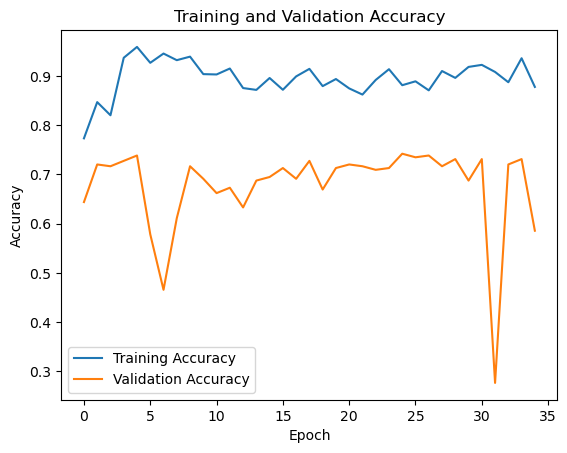

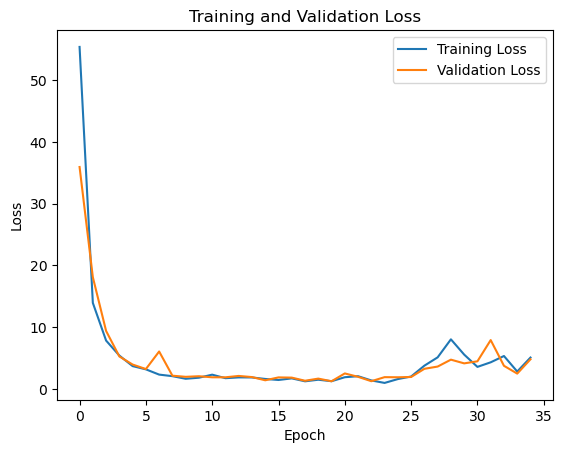

In [18]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8236 - loss: 1.0657
Test Accuracy: 90.50%
Test Loss: 1.0665


In [20]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step


array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

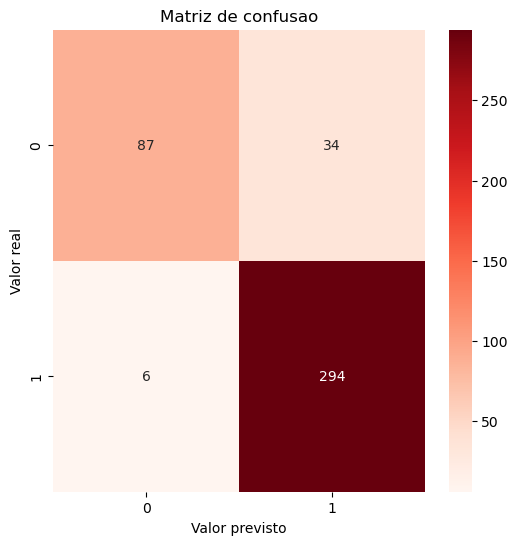

In [22]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [23]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 90.50%


In [1]:
#True negative, false positive, false negative, true positive.
#TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
#sensitivity = TP / (TP + FN)
print(87/(87+34))

#Specifity da definicao
#specificity = TN / (TN + FP)
print(294/(294+6))


0.71900826446281
0.98


In [24]:
#Data generators

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Found 4309 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [25]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

In [26]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose = 1, restore_best_weights=True)

In [28]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 1225s 4s/step - accuracy: 0.6974 - loss: 66.4023 - val_accuracy: 0.5091 - val_loss: 27.4599
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1212s 4s/step - accuracy: 0.8136 - loss: 14.1782 - val_accuracy: 0.7236 - val_loss: 11.9934
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1213s 4s/step - accuracy: 0.8935 - loss: 6.1292 - val_accuracy: 0.7309 - val_loss: 4.7099
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1199s 4s/step - accuracy: 0.8873 - loss: 4.3180 - val_accuracy: 0.7200 - val_loss: 3.7529
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1198s 4s/step - accuracy: 0.8387 - loss: 4.2762 - val_accuracy: 0.7309 - val_loss: 3.5325
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1200s 4s/step - accuracy: 0.8757 - loss: 3.1861 - val_accuracy: 0.7164 - val_loss: 2.4817
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1201s 4s/step - accuracy: 0.8892 - loss: 2.6384 - val_accuracy: 0.6727 - val_loss: 3.7656
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1201s 4s/step - accuracy: 0.9031 - loss: 2.3908 - 

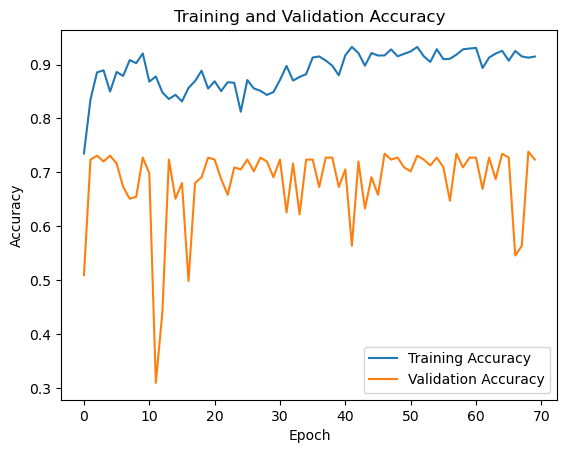

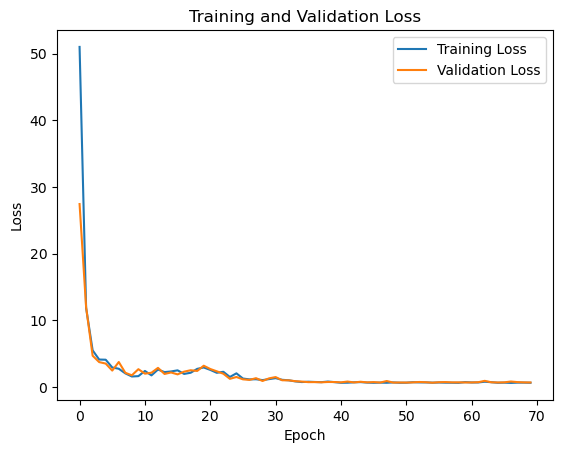

In [29]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.4264 - loss: 0.7959
Test Accuracy: 72.92%
Test Loss: 0.6625


In [31]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [32]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

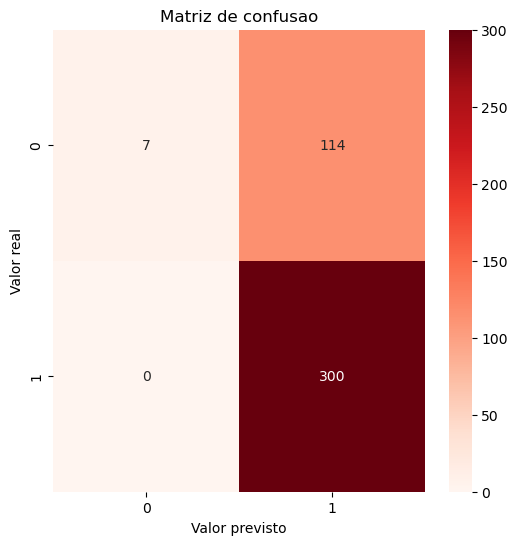

In [33]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [34]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 72.92%


In [2]:
#True negative, false positive, false negative, true positive.
#TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
#sensitivity = TP / (TP + FN)
print(7/(114+7))

#Specifity da definicao
#specificity = TN / (TN + FP)
print(300/(300))


0.05785123966942149
1.0


In [35]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

In [36]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose = 1, restore_best_weights=True)

In [38]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100


2024-06-22 03:20:38.971014: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1187053568 exceeds 10% of free system memory.
2024-06-22 03:20:39.333833: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1187053568 exceeds 10% of free system memory.


270/270 ━━━━━━━━━━━━━━━━━━━━ 2143s 8s/step - accuracy: 0.5564 - loss: 19.3628 - val_accuracy: 0.5491 - val_loss: 1.9609
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2140s 8s/step - accuracy: 0.6887 - loss: 1.5670 - val_accuracy: 0.7273 - val_loss: 0.9691
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2140s 8s/step - accuracy: 0.8651 - loss: 0.9658 - val_accuracy: 0.7273 - val_loss: 0.8221
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2140s 8s/step - accuracy: 0.9278 - loss: 0.8111 - val_accuracy: 0.7273 - val_loss: 0.7229
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2141s 8s/step - accuracy: 0.9532 - loss: 0.7425 - val_accuracy: 0.7273 - val_loss: 0.7120
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2140s 8s/step - accuracy: 0.9497 - loss: 0.7395 - val_accuracy: 0.7273 - val_loss: 0.7016
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2140s 8s/step - accuracy: 0.8998 - loss: 0.6968 - val_accuracy: 0.7273 - val_loss: 0.6969
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2140s 8s/step - accuracy: 0.9546 - loss: 0.6925 - val

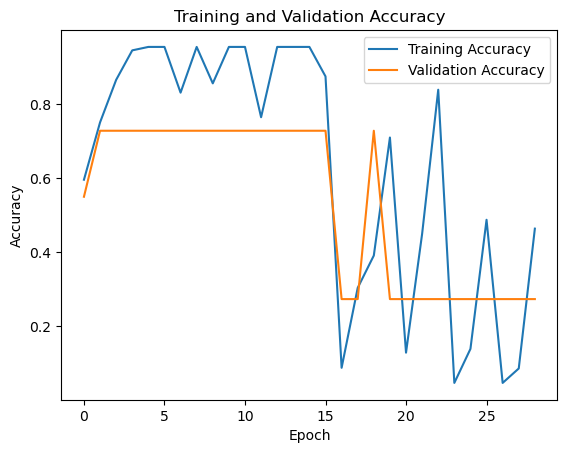

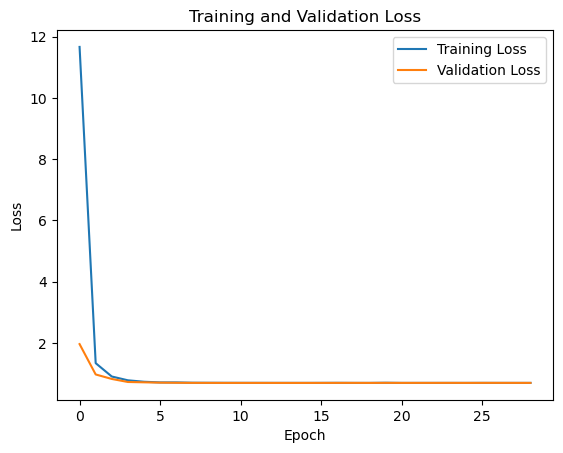

In [39]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.3887 - loss: 0.6943
Test Accuracy: 71.26%
Test Loss: 0.6925


In [41]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [42]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

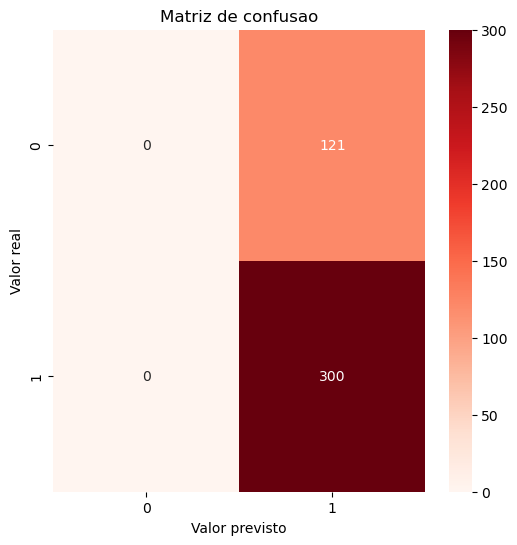

In [43]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [44]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 71.26%


In [4]:
#True negative, false positive, false negative, true positive.
#TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
#sensitivity = TP / (TP + FN)
print(0/(100+21))

#Specifity da definicao
#specificity = TN / (TN + FP)
print(300/(300))


0.0
1.0
